In [133]:
library(moments)

In [134]:
# read it in + prep
x <- read.csv("../data/lon2_2016-2018_season_adjust.csv.xz")
x$date <- as.Date(as.character(x$date), tz="UTC")
x$day <- factor(x$day, levels=c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))
#x <- x[x$date <= as.Date("2018-10-31", tz="UTC"), ]
tail(x)

,X,date,day,msm,bw,month,sa,model,trend,winter_summer,inter_week_midweek_peak,day_main,day_evening,day_lunch,day_evening_2,day_commute
315643,1869110,2018-12-31,Monday,1410,384094752763,12,-51521107403,426948443987,418476641297,16924439389,214779481,-40304697596,48461323762,-2099714787,1027542272,-25080564599
315644,186926,2018-12-31,Monday,1415,382580831653,12,-53126900643,419550047687,418476681217,16921952659,309098420,-43909748126,46578325598,-3525696018,672454870,-25296069734
315645,186936,2018-12-31,Monday,1420,382015488061,12,-53784434865,412126900424,418476773501,16919727513,403421912,-47493786095,44606817469,-4924561068,317114538,-25495572170
315646,186946,2018-12-31,Monday,1425,376805101470,12,-59087178293,404695359054,418476894440,16917653083,497732239,-51055152361,42550507593,-6285704198,-38269295,-25678750556
315647,186956,2018-12-31,Monday,1430,374710291045,12,-61274439182,397272123535,418477022226,16915652448,592055552,-54592196030,40413267499,-7598805141,-393445908,-25844986868
315648,186966,2018-12-31,Monday,1435,370865655966,12,-65211444722,389873212171,418477126873,16913591903,686381912,-58103292858,38199107794,-8853925194,-748192146,-25993904900


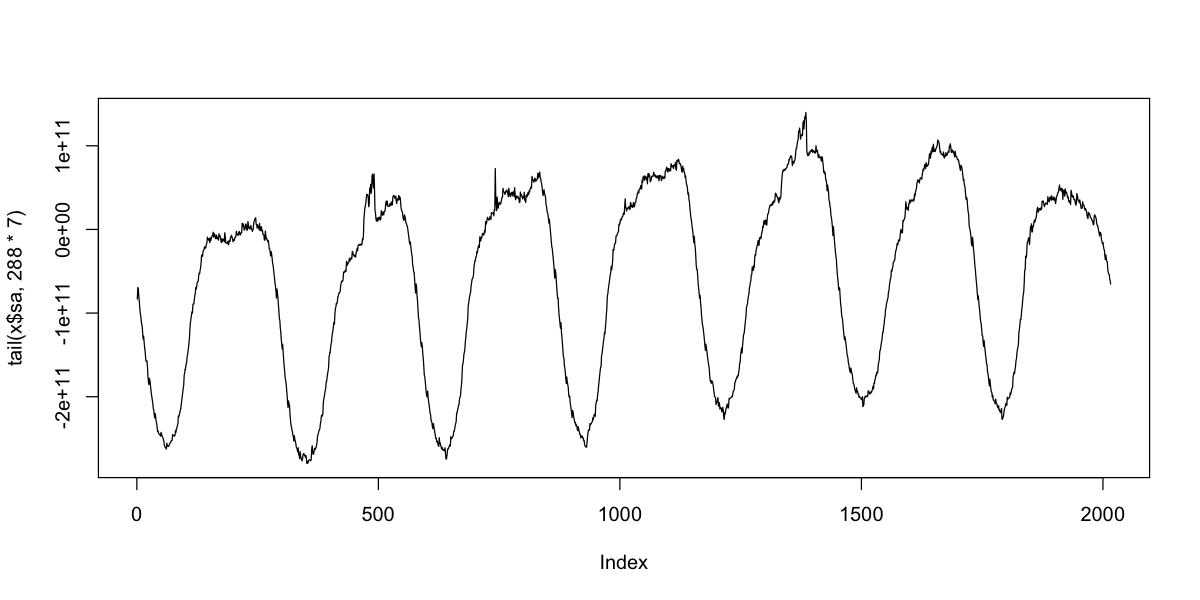

In [135]:
# quick peek.
options(repr.plot.width=10, repr.plot.height=5)
plot(tail(x$sa, 288*7), type="l")

In [136]:
# some stuff we need later..
times.5 <- format(seq(from = as.POSIXct("2018-08-02 00:00:00", tz="UTC"), to=as.POSIXct("2018-08-02 23:59:59", tz="UTC"), by="5 min"), "%H:%M")
# approx monthly daylight hours
daylight <- c(8,9,11,13,15,16,16.5,16,14,11,10,8)
# months
month.order <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")

In [137]:
# changepoint detection
# morning dip time
# pre "commute" peak time
# "commute" dip time
# evening peak time
phase_summary <- function(day, df=19) {
    a <- NA
    b <- NA
    c <- NA
    d <- NA
    ts.spline <- smooth.spline(day, df=df)
    changepoints <- which(c(NA, diff(sign(diff(ts.spline$y)))) != 0)
    N <- length(changepoints)
    if(N >= 2) {
        # morning dip is always the first one
        a <- changepoints[1]
        if(N >= 4) {
            # pre late afternoon dip is changepoint before penultimate
            
            
            b <- changepoints[N - 2]
            
            #b <- which(times.5 == "15:15") + which.max(day[which(times.5 == "15:20"):which(times.5 == "17:20")])
            
            # late afternoon dip is penultimate changepoint
            c <- changepoints[N - 1]
        }
        # evening peak is always the last one
        d <- changepoints[N]
    }
    list(changepoint=c(a, b, c, d), value=day[c(a, b, c, d)])
}

In [138]:
# some statistical moments
summary.stats <- function(x) {
    if(any(is.na(x))) return(NA)
    #x <- smooth.spline(x, df=18)$y
    c(summary(x), sd=sd(x), skewness=skewness(x), kurtosis=kurtosis(x))
}

In [139]:
# evening commute time (wide range) summary stats
commute.summary.stats <- function(x) {
    summary.stats(x[which(times.5 == "15:00"):which(times.5 == "19:30")])
}

In [140]:
# monthly cross section of vector indexed by Date.
cross_section <- function(x) {
    m <- tapply(x, months(as.Date(names(x))), mean, na.rm=T)
    m <- m[order(match(names(m), month.order))]
    m <- as.vector(m)
    m
    #smooth.spline(m)$y
}

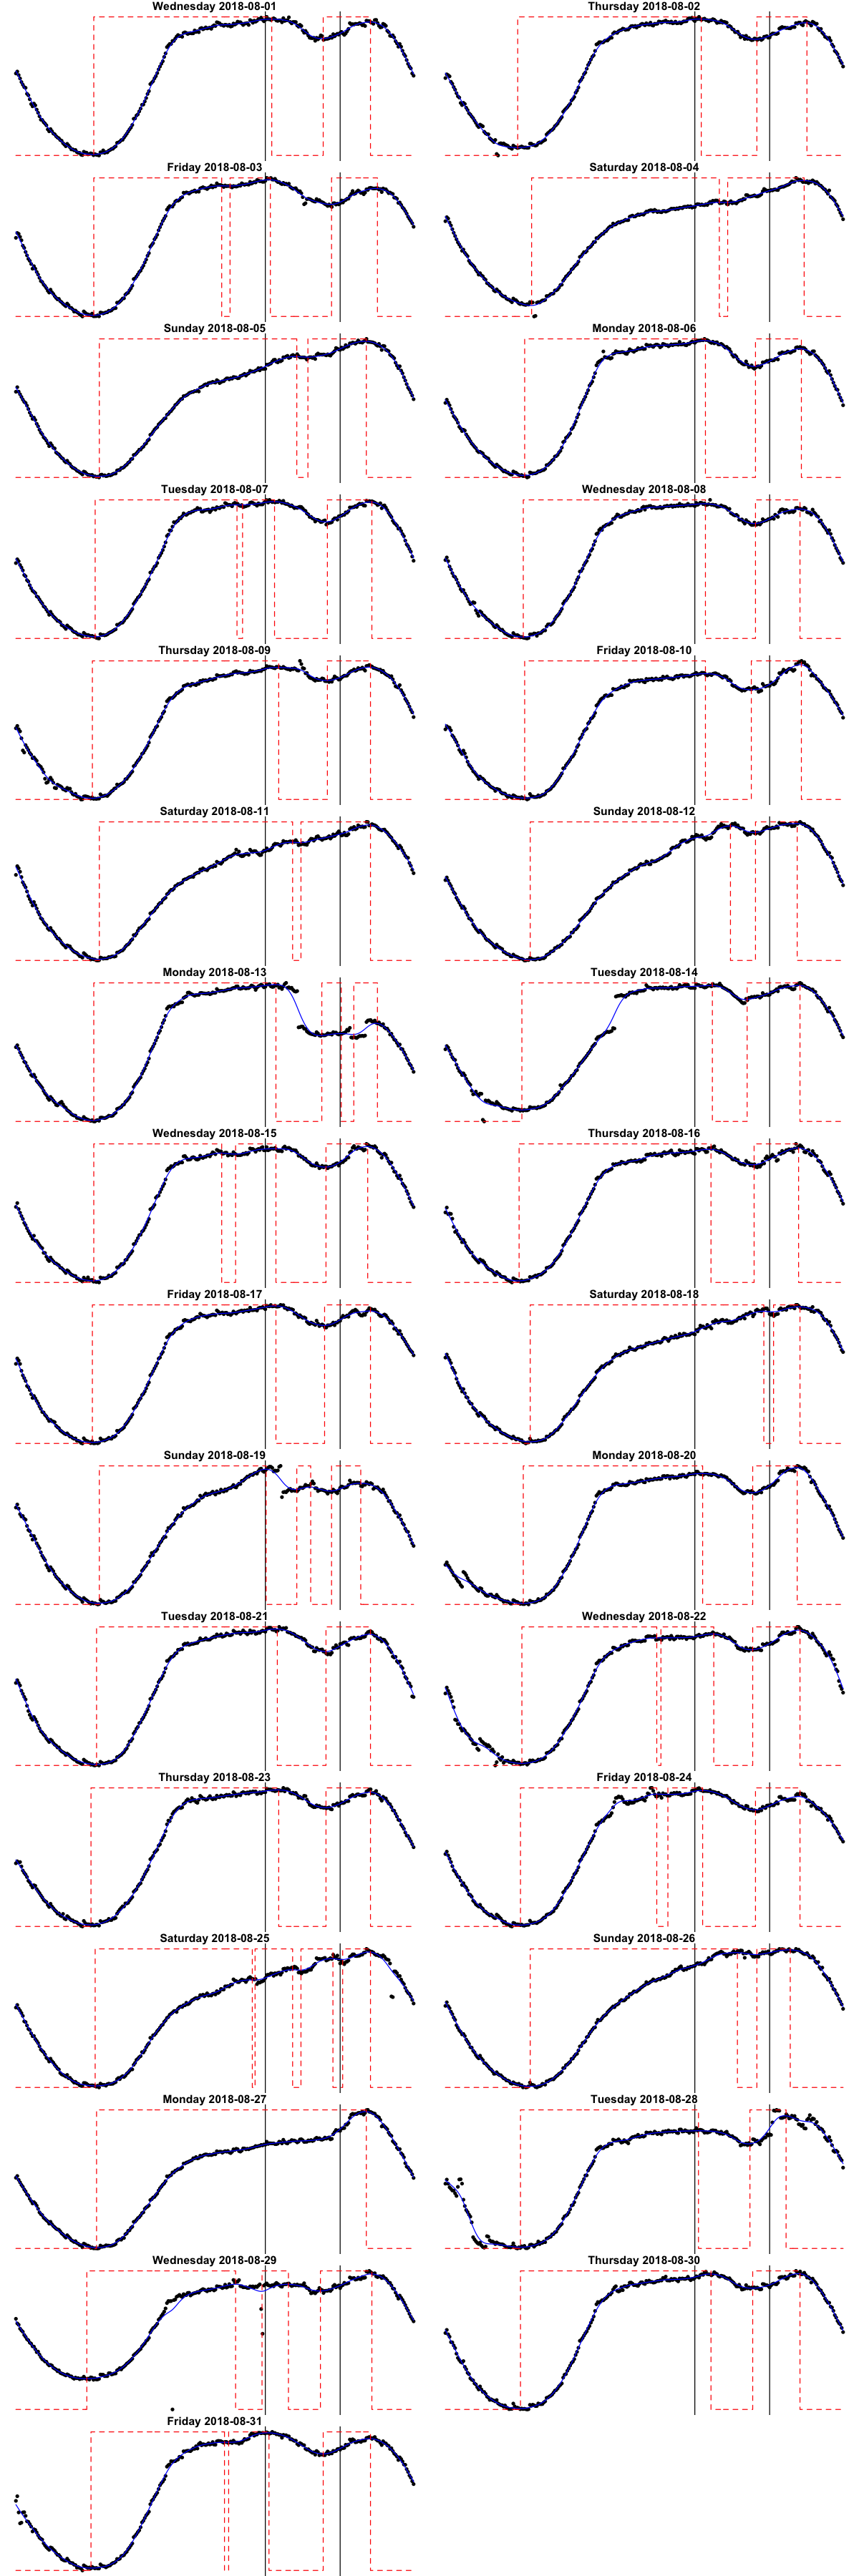

In [141]:
# quick check to see that changepoints detected ok.
options(repr.plot.width=10, repr.plot.height=30)
par(mfrow=c(16,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")
for(d in seq(from=as.Date("2018-08-01"), to=as.Date("2018-08-31"), by=1)) {
    d <- as.Date(d, origin = "1970-01-01", tz="UTC")
    day <- x[x$date == d, ]
    bw <- day$sa
    ts.spline <- smooth.spline(bw, df=24)
    plot(bw, main=paste(weekdays(as.Date(d)), as.Date(d)), pch=20)
    abline(v=which(times.5 == "15:00"))
    abline(v=which(times.5 == "19:30"))
    lines(ts.spline, col="blue", type="l")
    par(new=T)
    plot(sign(diff(ts.spline$y)), type="s", lty=2, col="red")
}

In [142]:
bandwidth.features.5 <- do.call(rbind, tapply(x$bw, x$date, function(x) {
    c(do.call(c, phase_summary(x)), 
      summary.stats(x), 
      evcom=commute.summary.stats(x), 
      evcom.diff=commute.summary.stats(diff(x)))
}))

bandwidth.features.5.sa1 <- do.call(rbind, tapply(x$sa, x$date, function(x) {
    c(do.call(c, phase_summary(x)), 
      summary.stats(x), 
      evcom=commute.summary.stats(x), 
      evcom.diff=commute.summary.stats(diff(x)))
}))

bandwidth.features.5.sa2 <- do.call(rbind, tapply(x$bw - x$winter_summer, x$date, function(x) {
    c(do.call(c, phase_summary(x)), 
      summary.stats(x), 
      evcom=commute.summary.stats(x), 
      evcom.diff=commute.summary.stats(diff(x)))
}))

# residuals
bandwidth.features.5.res <- do.call(rbind, tapply(x$bw - x$model, x$date, function(x) {
    c(summary.stats(x),
    evcom=commute.summary.stats(x))
}))

bandwidth.features.5 <- data.frame(raw=bandwidth.features.5, sa1=bandwidth.features.5.sa1, sa2=bandwidth.features.5.sa2,  res=bandwidth.features.5.res)

In [143]:
is_weekday <- function(x) {
    x != "Saturday" & x != "Sunday"
}

weekdays <- bandwidth.features.5[is_weekday(weekdays(as.Date(rownames(bandwidth.features.5)))), ]
avg.cp1 <- round(mean(weekdays$sa1.changepoint1, na.rm=T))
avg.cp2 <- round(mean(weekdays$sa1.changepoint2, na.rm=T))
avg.cp3 <- round(mean(weekdays$sa1.changepoint3, na.rm=T))
avg.cp4 <- round(mean(weekdays$sa1.changepoint4, na.rm=T))

work.fixed.1 <- which(times.5 == "10:00")
work.fixed.2 <- which(times.5 == "14:00")

# average changepoints - use when not detected for phase features.
bw.weekdays <- x[is_weekday(x$day), ]
mean.weekday <- as.vector(tapply(bw.weekdays$sa, bw.weekdays$msm, mean)) * 10^-9
ts.spline <- smooth.spline(mean.weekday, df=24)

[1] "04:25"

[1] "16:20"

[1] "18:20"

[1] "20:50"

[1] 131.3987

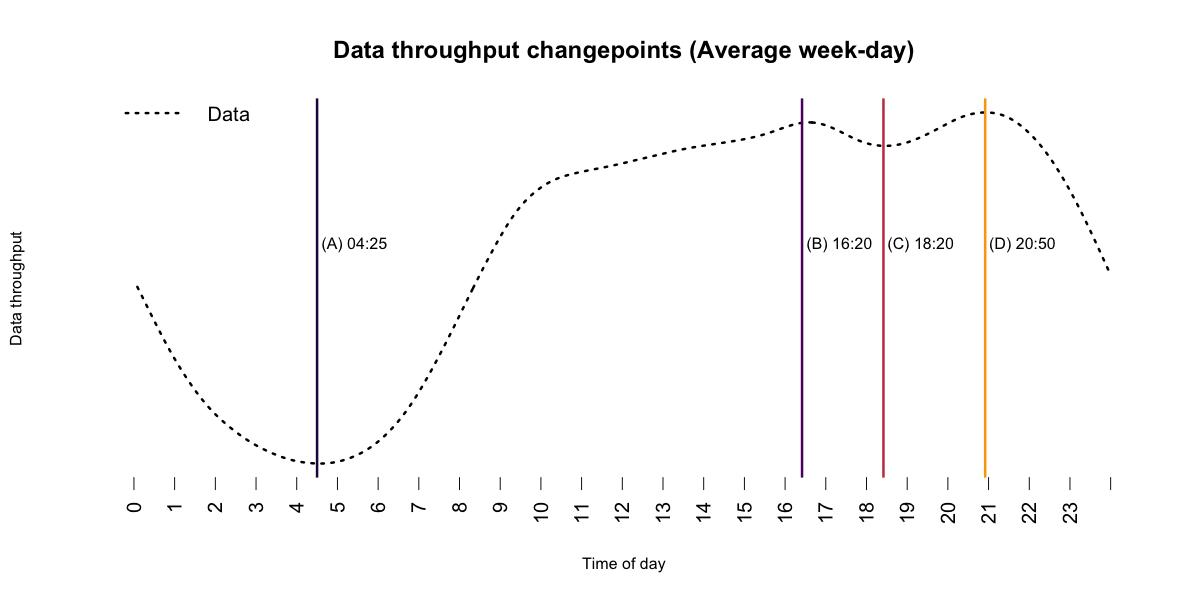

In [144]:
options(repr.plot.width=10, repr.plot.height=5)
stag <- seq(0, 288, 12) # mark hours 12am - 11pm
hour <- c(0:23, NA)
plot(ts.spline$y, type="l", bty="n", cex.lab=0.8, axes=F, lty=3, lwd=2,
    main="Data throughput changepoints (Average week-day)",
    ylab="Data throughput",
    xlab="Time of day")
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=2, at=stag, labels=hour)
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(200, 300, 400, 500), labels=c("200", "300", "400", "500"))
abline(v=avg.cp1, lwd=2, col="#240c4f")
abline(v=avg.cp2, lwd=2, col="#5d126e")
abline(v=avg.cp3, lwd=2, col="#c73e4c")
abline(v=avg.cp4, lwd=2, col="#fca50a")
#text(avg.cp1+5, , "A")
text(avg.cp1+11, mean(ts.spline$y), paste("(A)", times.5[avg.cp1]), cex=0.8)
text(avg.cp2+11, mean(ts.spline$y), paste("(B)", times.5[avg.cp2]), cex=0.8)
text(avg.cp3+11, mean(ts.spline$y), paste("(C)", times.5[avg.cp3]), cex=0.8)
text(avg.cp4+11, mean(ts.spline$y), paste("(D)", times.5[avg.cp4]), cex=0.8)

legend("topleft",
  legend = "Data",
  col = "#000000", 
  lty=3,
  lwd=2,
  bty = "n", 
  pt.cex = 1, 
  cex = 1, 
  text.col = "black", 
  horiz = F , 
  inset = c(0, 0))


#abline(v=work.fixed.1, col="red")
#abline(v=work.fixed.2, col="red")
times.5[avg.cp1]
times.5[avg.cp2]
times.5[avg.cp3]
times.5[avg.cp4]
max(ts.spline$y)

In [145]:
# animation

if(F){
options(repr.plot.width=10, repr.plot.height=6)

stag <- seq(0, 288, 12) # mark hours 12am - 11pm
hour <- c(0:23, NA)

par(mfrow=c(4,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")

i <- 0
for(d in seq(from=as.Date("2018-01-01"), to=as.Date("2018-12-31"), by=1)) {
    d <- as.Date(d, origin = "1970-01-01", tz="UTC")
    wd <- weekdays(d)
    if(!is_weekday(wd)) {
        next
    }
    day <- x[x$date == d, ]
    bw <- day$sa
    cps <- phase_summary(bw)
    ts.spline <- smooth.spline(bw, df=24)
    
    png(paste0("/tmp/lala/", sprintf("%04d", i), ".png"), width=600, height=300)
plot(ts.spline$y, type="l", bty="n", cex.lab=0.8, axes=F, lty=3, lwd=2,
    main=paste0(d, " (", wd, ")"),
    ylab="Data throughput",
    xlab="Time of day")
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=2, at=stag, labels=hour)
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(200, 300, 400, 500), labels=c("200", "300", "400", "500"))

abline(v=cps$changepoint[1], lwd=2, col="#240c4f")
abline(v=cps$changepoint[2], lwd=2, col="#5d126e")
abline(v=cps$changepoint[3], lwd=2, col="#c73e4c")
abline(v=cps$changepoint[4], lwd=2, col="#fca50a")

#text(avg.cp1+5, , "A")
#text(avg.cp1+11, mean(ts.spline$y), paste("(A)", times.5[avg.cp1]), cex=0.8)
#text(avg.cp2+11, mean(ts.spline$y), paste("(B)", times.5[avg.cp2]), cex=0.8)
#text(avg.cp3+11, mean(ts.spline$y), paste("(C)", times.5[avg.cp3]), cex=0.8)
#text(avg.cp4+11, mean(ts.spline$y), paste("(D)", times.5[avg.cp4]), cex=0.8)

legend("topleft",
  legend = "Data",
  col = "#000000", 
  lty=3,
  lwd=2,
  bty = "n", 
  pt.cex = 1, 
  cex = 1, 
  text.col = "black", 
  horiz = F , 
  inset = c(0, 0))
    
    dev.off()
    i <- i+1
}
}

In [146]:
phase.features <- NULL

for(d in rownames(bandwidth.features.5)) {
    features <- bandwidth.features.5[as.Date(rownames(bandwidth.features.5)) == d, ]
    cp1 <- features$sa1.changepoint1
    cp2 <- features$sa1.changepoint2
    cp3 <- features$sa1.changepoint3
    cp4 <- features$sa1.changepoint4
    
    day <- x[x$date == d, ]
    bw <- day$sa
    res <- day$bw - day$model
    
    if(is.na(cp1) || is.na(cp2)) {
      cp1 <- avg.cp1
      cp2 <- avg.cp2
    }
    
    if(is.na(cp2) || is.na(cp4)) {
        cp2 <- avg.cp2
        cp4 <- avg.cp4
    }
    
    fixed.work.raw <- day$bw
    fixed.work.sa1 <- day$bw - day$trend - day$winter_summer - day$inter_week_midweek_peak
    fixed.work.sa2 <- day$bw - day$trend - day$winter_summer
    fixed.work.sa3 <- day$bw - day$winter_summer - day$inter_week_midweek_peak
    fixed.work.sa4 <- day$bw - day$winter_summer
    
    phase.features <- rbind(phase.features,
                            data.frame(mean.work=mean(bw[cp1:cp2]), # mean work (seasonally adjusted) value.
                                       mean.work.res=mean(res[cp1:cp2]), # mean residual during work time
                                       mean.fixed.work.raw=mean(fixed.work.raw[work.fixed.1:work.fixed.2]),
                                       mean.fixed.work.sa1=mean(fixed.work.sa1[work.fixed.1:work.fixed.2]),
                                       mean.fixed.work.sa2=mean(fixed.work.sa2[work.fixed.1:work.fixed.2]),
                                       mean.fixed.work.sa3=mean(fixed.work.sa3[work.fixed.1:work.fixed.2]),
                                       mean.fixed.work.sa4=mean(fixed.work.sa4[work.fixed.1:work.fixed.2]),
                                       mean.commute.res=mean(res[cp2:cp4]), # mean residual during commute phase
                                       mean.commute.abs.diff=mean(abs(diff(bw[cp2:cp4]))))) # idea of magnitude
}

In [147]:
head(phase.features)

mean.work,mean.work.res,mean.fixed.work.raw,mean.fixed.work.sa1,mean.fixed.work.sa2,mean.fixed.work.sa3,mean.fixed.work.sa4,mean.commute.res,mean.commute.abs.diff
-42307999962,-53454175945,334558172345,20280749168,15902758090,342171711369,337793720291,20605383851,2412067212
2196749087,-3728195975,355437741190,51228206440,35222718900,373112769279,357107281739,53278823461,1994113747
-4693273512,13719484172,370212880852,64865288999,48781883062,386766198246,370682792309,55676862793,2755421693
35494700376,22108370045,430818563573,113179256938,108654266053,435090132139,430565141254,17342724729,3225606776
21784734854,5415846603,426840838905,94372368893,104328749433,416276020245,426232400785,27987778055,2661918882
15584263790,16860724765,427741524322,88256256447,104830221677,410143741274,426717706504,38918595825,2989170675


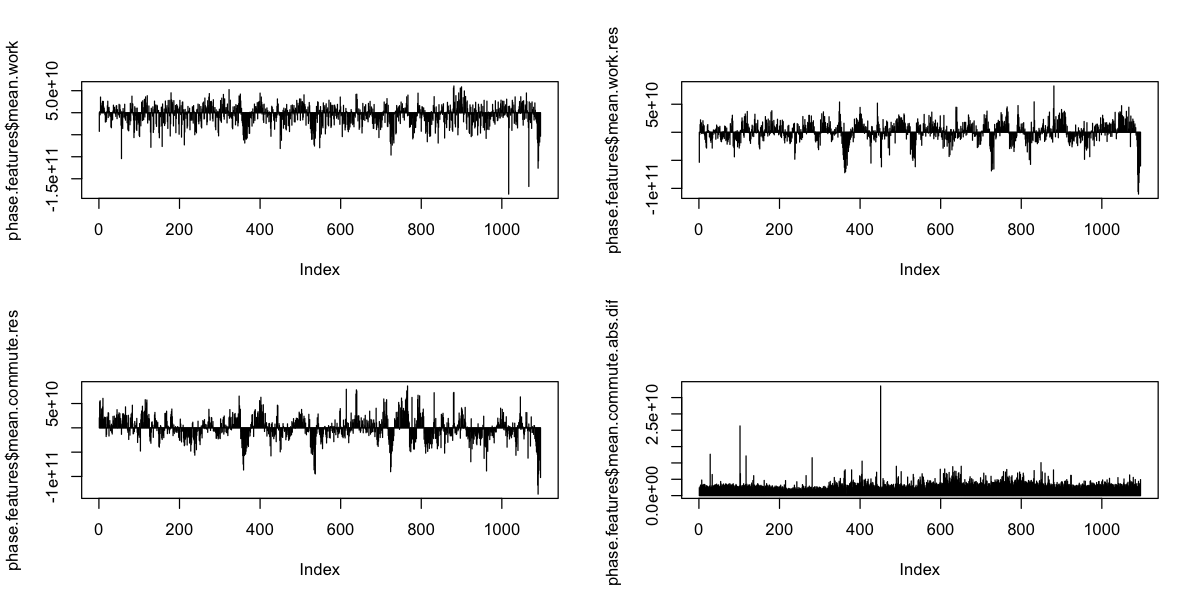

In [148]:
par(mfrow=c(2,2))
plot(phase.features$mean.work, type="h")
plot(phase.features$mean.work.res, type="h")
plot(phase.features$mean.commute.res, type="h")
plot(phase.features$mean.commute.abs.diff, type="h")

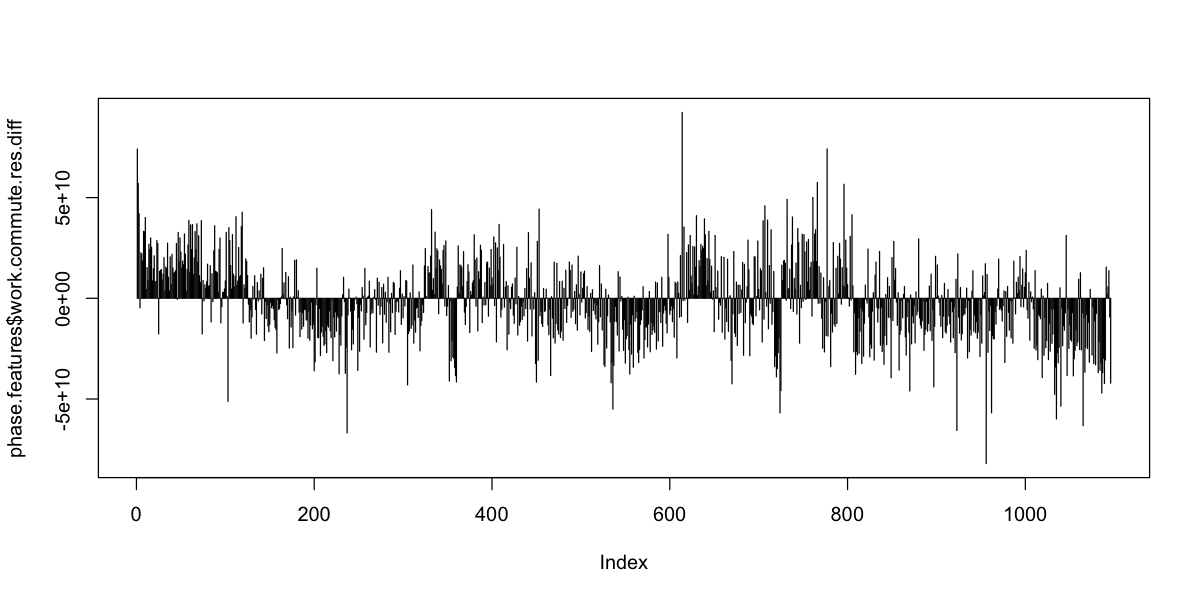

In [149]:
# difference in work time residuals and commute time residuals -nv = commute phase residual lower than work times.
phase.features$work.commute.res.diff <- phase.features$mean.commute.res - phase.features$mean.work.res
plot(phase.features$work.commute.res.diff, type="h")

In [150]:
bandwidth.features.5 <- data.frame(bandwidth.features.5, phase.features)

In [151]:
# the features
head(bandwidth.features.5)

,raw.changepoint1,raw.changepoint2,raw.changepoint3,raw.changepoint4,raw.value1,raw.value2,raw.value3,raw.value4,raw.Min.,raw.1st.Qu.,⋯,mean.work,mean.work.res,mean.fixed.work.raw,mean.fixed.work.sa1,mean.fixed.work.sa2,mean.fixed.work.sa3,mean.fixed.work.sa4,mean.commute.res,mean.commute.abs.diff,work.commute.res.diff
2016-01-01,70,NA,NA,250,142094581805,NA,NA,449523344203,141638139757,199889909702,⋯,-42307999962,-53454175945,334558172345,20280749168,15902758090,342171711369,337793720291,20605383851,2412067212,74059559796
2016-01-02,67,199,210,233,148035334122,443893943836,435825414109,461636251086,147168408380,210161041076,⋯,2196749087,-3728195975,355437741190,51228206440,35222718900,373112769279,357107281739,53278823461,1994113747,57007019436
2016-01-03,69,NA,NA,241,154515455881,NA,NA,483353078032,153615775620,216134036370,⋯,-4693273512,13719484172,370212880852,64865288999,48781883062,386766198246,370682792309,55676862793,2755421693,41957378621
2016-01-04,58,197,216,249,148035131315,464677045201,452847569505,487948966186,148035131315,229469855618,⋯,35494700376,22108370045,430818563573,113179256938,108654266053,435090132139,430565141254,17342724729,3225606776,-4765645316
2016-01-05,56,202,222,249,159042717644,482618200642,463088495768,499520218623,156657135298,232673160144,⋯,21784734854,5415846603,426840838905,94372368893,104328749433,416276020245,426232400785,27987778055,2661918882,22571931452
2016-01-06,55,202,218,249,155683624698,475163929776,470021276110,495608913792,149765122060,232610076776,⋯,15584263790,16860724765,427741524322,88256256447,104830221677,410143741274,426717706504,38918595825,2989170675,22057871060


[1] "20:15" "20:25" "20:30" "20:35" "20:40" "20:45" "20:50" "21:00" "21:00"
[10] "21:00" "21:00" "21:05"

[1] 244 246 247 248 249 250 251 253 253 253 253 254

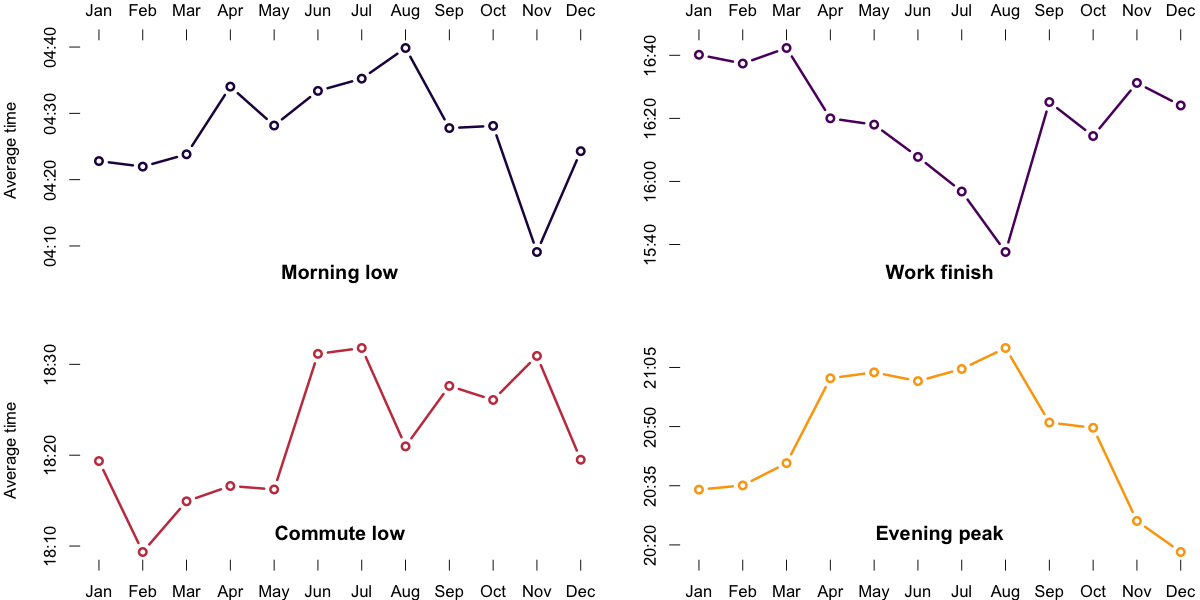

In [154]:
weekdays <- bandwidth.features.5[is_weekday(weekdays(as.Date(rownames(bandwidth.features.5)))), ]
cp1 <- weekdays[,"sa1.changepoint1"]
cp2 <- weekdays[,"sa1.changepoint2"]
cp3 <- weekdays[,"sa1.changepoint3"]
cp4 <- weekdays[,"sa1.changepoint4"]
names(cp1) <- rownames(weekdays)
names(cp2) <- rownames(weekdays)
names(cp3) <- rownames(weekdays)
names(cp4) <- rownames(weekdays)
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(2,2),mar=c(2,4,2,0),bty="n")
plot(cross_section(cp1), type="b", col="#240c4f", lwd=2, axes=F, ylab="Average time")
title("Morning low", line = -12, adj = 0.5)
axis(3, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=1:12, labels=c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(51, 53, 55, 57), labels=c("04:10", "04:20", "04:30", "04:40"))
plot(cross_section(cp2), type="b", col="#5d126e", lwd=2, axes=F, ylab="")
title("Work finish", line = -12, adj = 0.5)
axis(3, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=1:12, labels=c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(189, 193, 197, 201), labels=c("15:40", "16:00", "16:20", "16:40"))
plot(cross_section(cp3), type="b", col="#c73e4c", lwd=2, axes=F, ylab="Average time")
title("Commute low", line = -10, adj = 0.5)
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=1:12, labels=c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(219, 221, 223), labels=c("18:10", "18:20", "18:30"))
plot(cross_section(cp4), type="b", col="#fca50a", lwd=2, axes=F, ylab="")
title("Evening peak", line = -10, adj = 0.5)
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=1:12, labels=c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(245, 248, 251, 254), labels=c("20:20", "20:35", "20:50", "21:05"))

times.5[sort(as.integer(cross_section(cp4)))]
sort(as.integer(cross_section(cp4)))


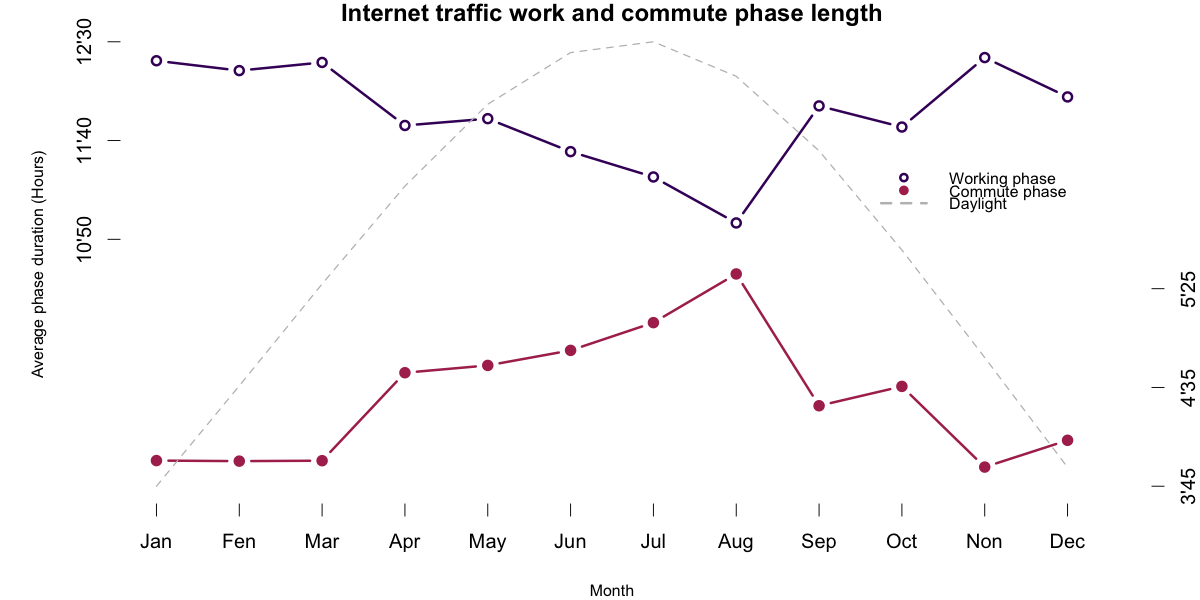

In [131]:
options(repr.plot.width=10, repr.plot.height=5)
par(mar=c(4,5,1,4), bty="n")
plot(cross_section(cp2-cp1), type="b", ylim=c(105, 150), cex.lab=0.8, axes=F, lty=1, col="#420a68", lwd=2,
     main="Internet traffic work and commute phase length",
     ylab="Average phase duration (Hours)",
     xlab="Month")
lines(60+cross_section(cp4-cp2), type="b", lty=1, col="#ae305c", lwd=2, pch=19)
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=1:12, labels=c("Jan", "Fen", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Non", "Dec"))
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(130, 140, 150), labels=c("10'50", "11'40", "12'30"))
axis(2, side=4, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=3, at=c(105, 115, 125), labels=c("3'45", "4'35", "5'25"))
legend("bottomright",
  legend = c("Working phase", "Commute phase", "Daylight"), 
  col = c("#420a68", "#ae305c", "grey"), 
  lty=c(NA,NA,2),
  lwd=c(2,2,2),
  pch=c(1,19,NA),
  bty = "n",
  inset = c(-0.05, 0.6), horiz=F, cex=0.8)
#legend("topright", "Mean", lty=3, lwd=2, cex=0.8, col="#f7750f", bty="n")     
par(new=T)
plot(smooth.spline(daylight, df=4)$y, type="l",col="grey", lty=2, axes=F, xlab="", ylab="")

In [63]:
#options(repr.plot.width=10, repr.plot.height=10)
#par(mfrow=c(2,1))
#with(x, plot(tail(head(bw, 288*90), 288*30), type="l"))
#with(x, lines(tail(head(model, 288*90), 288*30), type="l", lty=1, col="red"))
#with(x, plot(tail(head(bw-model, 288*90), 288*30), type="h"))

In [64]:
colnames(bandwidth.features.5)

[1] "raw.changepoint1"        "raw.changepoint2"       
  [3] "raw.changepoint3"        "raw.changepoint4"       
  [5] "raw.value1"              "raw.value2"             
  [7] "raw.value3"              "raw.value4"             
  [9] "raw.Min."                "raw.1st.Qu."            
 [11] "raw.Median"              "raw.Mean"               
 [13] "raw.3rd.Qu."             "raw.Max."               
 [15] "raw.sd"                  "raw.skewness"           
 [17] "raw.kurtosis"            "raw.evcom.Min."         
 [19] "raw.evcom.1st.Qu."       "raw.evcom.Median"       
 [21] "raw.evcom.Mean"          "raw.evcom.3rd.Qu."      
 [23] "raw.evcom.Max."          "raw.evcom.sd"           
 [25] "raw.evcom.skewness"      "raw.evcom.kurtosis"     
 [27] "raw.evcom.diff.Min."     "raw.evcom.diff.1st.Qu." 
 [29] "raw.evcom.diff.Median"   "raw.evcom.diff.Mean"    
 [31] "raw.evcom.diff.3rd.Qu."  "raw.evcom.diff.Max."    
 [33] "raw.evcom.diff.sd"       "raw.evcom.diff.skewness"
 [35] "raw.evcom.diff.kurtosis" "sa1.changepoint1"       
 [37] "sa1.changepoint2"        "sa1.changepoint3"       
 [39] "sa1.changepoint4"        "sa1.value1"             
 [41] "sa1.value2"              "sa1.value3"             
 [43] "sa1.value4"              "sa1.Min."               
 [45] "sa1.1st.Qu."             "sa1.Median"             
 [47] "sa1.Mean"                "sa1.3rd.Qu."            
 [49] "sa1.Max."                "sa1.sd"                 
 [51] "sa1.skewness"            "sa1.kurtosis"           
 [53] "sa1.evcom.Min."          "sa1.evcom.1st.Qu."      
 [55] "sa1.evcom.Median"        "sa1.evcom.Mean"         
 [57] "sa1.evcom.3rd.Qu."       "sa1.evcom.Max."         
 [59] "sa1.evcom.sd"            "sa1.evcom.skewness"     
 [61] "sa1.evcom.kurtosis"      "sa1.evcom.diff.Min."    
 [63] "sa1.evcom.diff.1st.Qu."  "sa1.evcom.diff.Median"  
 [65] "sa1.evcom.diff.Mean"     "sa1.evcom.diff.3rd.Qu." 
 [67] "sa1.evcom.diff.Max."     "sa1.evcom.diff.sd"      
 [69] "sa1.evcom.diff.skewness" "sa1.evcom.diff.kurtosis"
 [71] "sa2.changepoint1"        "sa2.changepoint2"       
 [73] "sa2.changepoint3"        "sa2.changepoint4"       
 [75] "sa2.value1"              "sa2.value2"             
 [77] "sa2.value3"              "sa2.value4"             
 [79] "sa2.Min."                "sa2.1st.Qu."            
 [81] "sa2.Median"              "sa2.Mean"               
 [83] "sa2.3rd.Qu."             "sa2.Max."               
 [85] "sa2.sd"                  "sa2.skewness"           
 [87] "sa2.kurtosis"            "sa2.evcom.Min."         
 [89] "sa2.evcom.1st.Qu."       "sa2.evcom.Median"       
 [91] "sa2.evcom.Mean"          "sa2.evcom.3rd.Qu."      
 [93] "sa2.evcom.Max."          "sa2.evcom.sd"           
 [95] "sa2.evcom.skewness"      "sa2.evcom.kurtosis"     
 [97] "sa2.evcom.diff.Min."     "sa2.evcom.diff.1st.Qu." 
 [99] "sa2.evcom.diff.Median"   "sa2.evcom.diff.Mean"    
[101] "sa2.evcom.diff.3rd.Qu."  "sa2.evcom.diff.Max."    
[103] "sa2.evcom.diff.sd"       "sa2.evcom.diff.skewness"
[105] "sa2.evcom.diff.kurtosis" "res.Min."               
[107] "res.1st.Qu."             "res.Median"             
[109] "res.Mean"                "res.3rd.Qu."            
[111] "res.Max."                "res.sd"                 
[113] "res.skewness"            "res.kurtosis"           
[115] "res.evcom.Min."          "res.evcom.1st.Qu."      
[117] "res.evcom.Median"        "res.evcom.Mean"         
[119] "res.evcom.3rd.Qu."       "res.evcom.Max."         
[121] "res.evcom.sd"            "res.evcom.skewness"     
[123] "res.evcom.kurtosis"      "mean.work"              
[125] "mean.work.res"           "mean.fixed.work.raw"    
[127] "mean.fixed.work.sa1"     "mean.fixed.work.sa2"    
[129] "mean.fixed.work.sa3"     "mean.fixed.work.sa4"    
[131] "mean.commute.res"        "mean.commute.abs.diff"  
[133] "work.commute.res.diff"   "work.day.len"           
[135] "day.len"                 "les.time.len"           
[137] "work.com.low.len"        "work.day.width"         


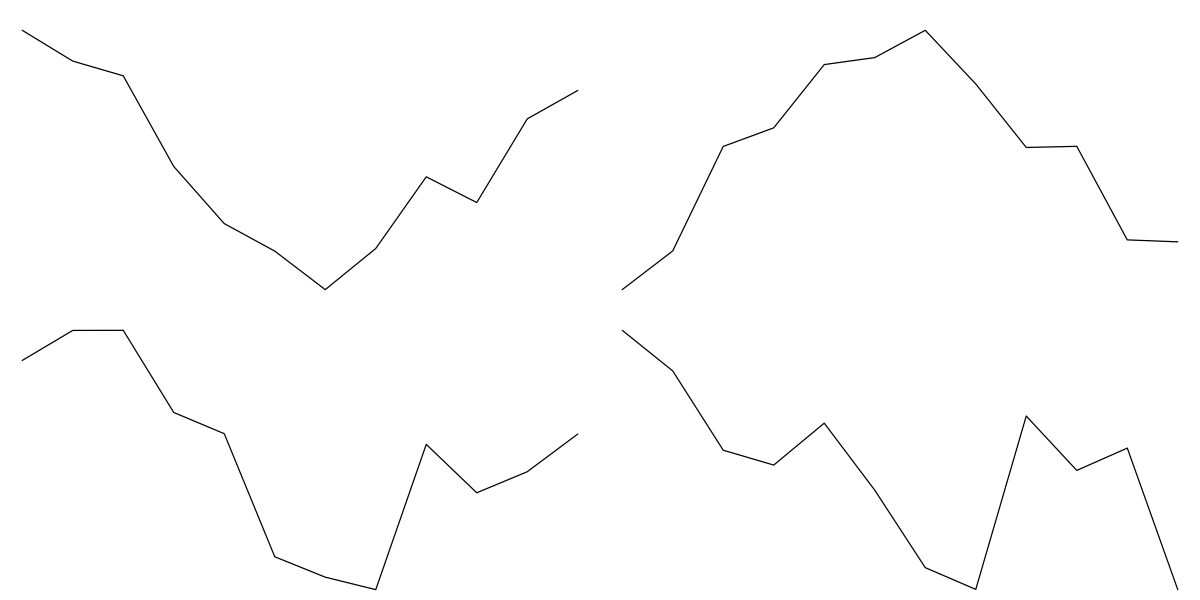

In [65]:
# these have best R^2 in internet vs road traffic feature comp, check for monthly seasonality...
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(2,2),mar=c(0,0,1,0),bty="n",xaxt="n",yaxt="n")

x <- bandwidth.features.5$sa1.skewness
names(x) <- rownames(bandwidth.features.5)
plot(cross_section(x), type="l")
# :(

x <- bandwidth.features.5$sa1.kurtosis
names(x) <- rownames(bandwidth.features.5)
plot(cross_section(x), type="l")
# :(

x <- bandwidth.features.5$sa1.evcom.diff.Mean
names(x) <- rownames(bandwidth.features.5)
plot(cross_section(x), type="l")
# ?

x <- bandwidth.features.5$mean.commute.res
names(x) <- rownames(bandwidth.features.5)
plot(cross_section(x), type="l")
# ?

In [66]:
# some 2nd order
bandwidth.features.5$work.day.len <- with(bandwidth.features.5, sa1.changepoint2 - sa1.changepoint1)
bandwidth.features.5$day.len <- with(bandwidth.features.5, sa1.changepoint4 - sa1.changepoint1)
bandwidth.features.5$les.time.len <- with(bandwidth.features.5, sa1.changepoint4 - sa1.changepoint2)
bandwidth.features.5$work.com.low.len <- with(bandwidth.features.5, sa1.changepoint3 - sa1.changepoint2)
bandwidth.features.5$work.day.width <- with(bandwidth.features.5, raw.value2 - raw.value1)
bandwidth.features.5$commute.depth <- with(bandwidth.features.5, ((raw.value2 + raw.value4) / 2) - raw.value3)

In [28]:
#write.csv(bandwidth.features.5, "bandwidth_features_london.csv", quote=F)

In [67]:
head(bandwidth.features.5[, "work.day.len"])

[1]  NA 132  NA 139 145 147

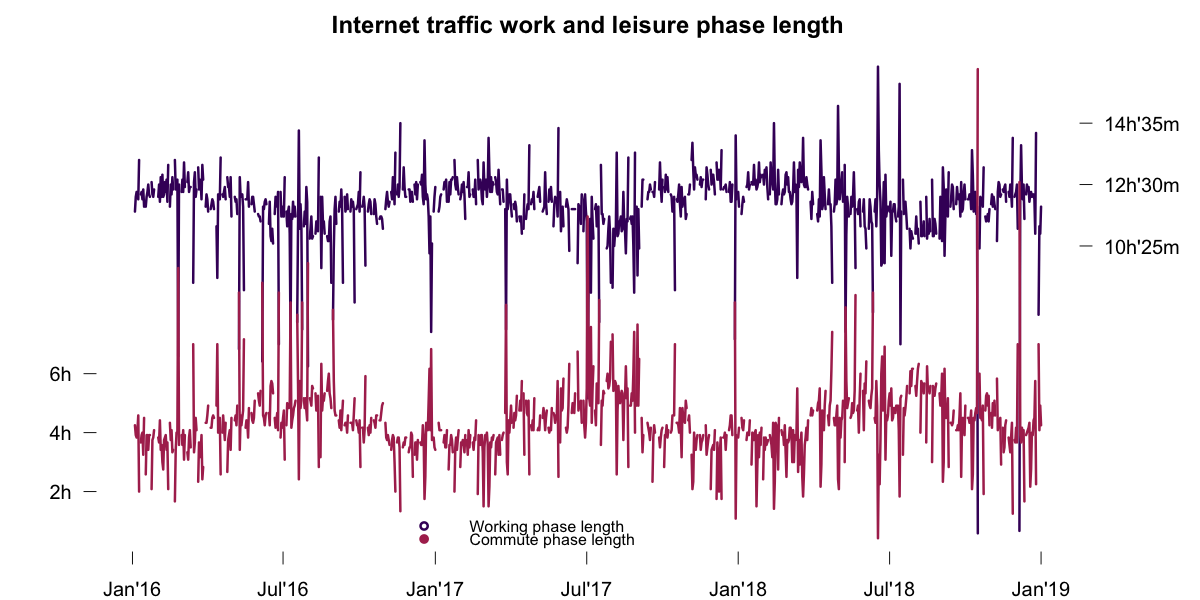

In [129]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,1),mar=c(2,4,2,5),bty="n")
plot(bandwidth.features.5$work.day.len, type="l", col="#420a68", lwd=2, axes=F, ylab="", main="Internet traffic work and leisure phase length")
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=c(25,49,73), labels=c("2h", "4h", "6h"))
lines(bandwidth.features.5$les.time.len, type="l", col="#ae305c", lwd=2)
axis(4, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=c(125,150,175),
     labels=c("10h'25m", "12h'30m", "14h'35m"))
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=1, at=c(1, 182, 365, 547, 729, 911, 1093),
     labels=c("Jan'16", "Jul'16", "Jan'17", "Jul'17", "Jan'18", "Jul'18", "Jan'19"))
legend("bottomright",
  legend = c("Working phase length", "Commute phase length"), 
  col = c("#420a68", "#ae305c"), 
  lty=c(NA,NA),
  lwd=c(2,2),
  pch=c(1,19),
  bty = "n",
  inset = c(0.333, 0), horiz=F, cex=0.8)